In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
# from pyts.approximation import SymbolicAggregateApproximation
# from saxpy.znorm import znorm
# from saxpy.paa import paa
# from saxpy.sax import ts_to_string
from gensim.models import Word2Vec

%matplotlib inline

In [3]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None

In [4]:
data_dict = load_SMD_dataset("./datasets/anomaly/SMD/processed", "machine-1-1")
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
# data_dict = pp.normalize(data_dict,method="standard")
data_dict = pp.discretize(data_dict,n_bins=100)
vocab_size = pp.build_vocab(data_dict)
# vocab_size

2021-01-29 12:53:29,259 P71778 INFO Loading machine-1-1 dataset
2021-01-29 12:53:29,292 P71778 INFO Saving preprocessor into ./checkpoints/20210129-125329/preprocessor.pkl
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 16 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 17 is constant and will be replaced with 0.
  "replaced with 0." % jj

1 files found.


In [15]:
sentences = [list(item) for item in data_dict["train"].T.astype(str)]
model = Word2Vec(sentences=sentences, size=10, window=5, min_count=1, workers=4)
# model.save("word2vec.model")

2021-01-29 12:55:37,837 P71778 WARNING consider setting layer size to a multiple of 4 for greater performance
2021-01-29 12:55:37,848 P71778 INFO collecting all words and their counts
2021-01-29 12:55:37,849 P71778 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-29 12:55:38,022 P71778 INFO collected 100 word types from a corpus of 1082202 raw words and 38 sentences
2021-01-29 12:55:38,040 P71778 INFO Loading a fresh vocabulary
2021-01-29 12:55:38,042 P71778 INFO effective_min_count=1 retains 100 unique words (100% of original 100, drops 0)
2021-01-29 12:55:38,043 P71778 INFO effective_min_count=1 leaves 1082202 word corpus (100% of original 1082202, drops 0)
2021-01-29 12:55:38,044 P71778 INFO deleting the raw counts dictionary of 100 items
2021-01-29 12:55:38,045 P71778 INFO sample=0.001 downsamples 50 most-common words
2021-01-29 12:55:38,064 P71778 INFO downsampling leaves estimated 325042 word corpus (30.0% of prior 1082202)
2021-01-29 12:55:38,066 P7

In [34]:
pretrain_mat = torch.FloatTensor(np.array([model.wv[str(i)] for i in range(vocab_size)]))
pretrain_mat.shape

torch.Size([100, 10])

In [30]:
window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-01-29 14:31:41,740 P71778 INFO Generating sliding windows (size 32).
2021-01-29 14:31:41,932 P71778 INFO Train windows #: (889, 32, 38)
2021-01-29 14:31:41,933 P71778 INFO Test windows #: (28447, 32, 38)


In [37]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]
params["embedding_dim"] = 10

In [38]:
encoder = MultiLSTMEncoder(vocab_size=vocab_size, pretrain_mat=pretrain_mat, **params)

2021-01-29 14:33:03,868 P71778 INFO Compiling finished.


In [40]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-01-29 14:33:29,692 P71778 INFO Start training for 14 batches.
2021-01-29 14:33:32,913 P71778 INFO Epoch: 1, loss: 1.780
2021-01-29 14:33:36,350 P71778 INFO Epoch: 2, loss: 1.725
2021-01-29 14:33:39,386 P71778 INFO Epoch: 3, loss: 1.690
2021-01-29 14:33:42,692 P71778 INFO Epoch: 4, loss: 1.671
2021-01-29 14:33:45,902 P71778 INFO Epoch: 5, loss: 1.641
2021-01-29 14:33:49,182 P71778 INFO Epoch: 6, loss: 1.615
2021-01-29 14:33:52,611 P71778 INFO Epoch: 7, loss: 1.584
2021-01-29 14:33:55,776 P71778 INFO Epoch: 8, loss: 1.550
2021-01-29 14:33:58,858 P71778 INFO Epoch: 9, loss: 1.525
2021-01-29 14:34:02,001 P71778 INFO Epoch: 10, loss: 1.500
2021-01-29 14:34:05,085 P71778 INFO Epoch: 11, loss: 1.486
2021-01-29 14:34:08,174 P71778 INFO Epoch: 12, loss: 1.460
2021-01-29 14:34:11,334 P71778 INFO Epoch: 13, loss: 1.428
2021-01-29 14:34:14,641 P71778 INFO Epoch: 14, loss: 1.409
2021-01-29 14:34:17,750 P71778 INFO Epoch: 15, loss: 1.383
2021-01-29 14:34:20,984 P71778 INFO Epoch: 16, loss: 1.35

KeyboardInterrupt: 

In [10]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"],)

2021-01-29 12:40:52,360 P71268 INFO Evaluating


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
plt.plot(score_dict["score"])

In [44]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader

# loader = test_iterator.loader
# encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()
diff_list = recst_list-real_list

0.6563303491898945


In [45]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)

(889, 38)
(889, 38)
(889, 38)


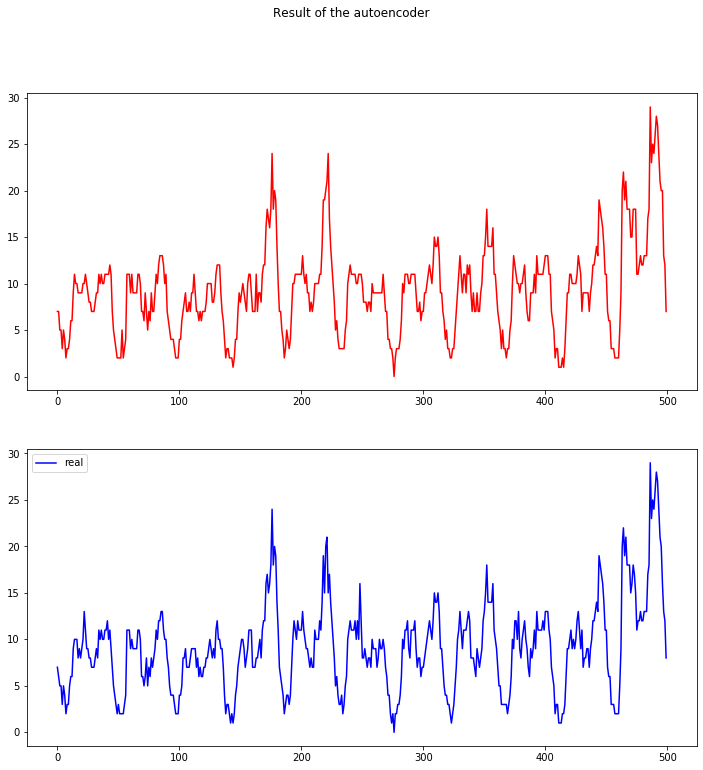

In [46]:
dims = [0,1]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
i=20
# for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
ax[0].plot(recst_list[0:500,i].reshape(-1), 'r', label='recst')
ax[1].plot(real_list[0:500,i].reshape(-1), 'b', label='real')
# ax[1].plot(diff_list[15000:-1].reshape(-1), 'b', label='real')
# ax[1].plot(window_dict["test_labels"][15000:, -1].reshape(-1)+0.3, 'r', label='real')
# ax[0].legend(loc='best')
# ax[1].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()